In [1]:


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/netflix-shows/netflix_titles.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from collections import Counter
from wordcloud import WordCloud

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv") 

In [4]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
data.shape

(8807, 12)

In [6]:
columns = list(data.columns)
columns

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


There are 12 columns in the dataset, most of which are objects containing strings. 

Data type conversion for "data_added"

In [8]:
data['date_added'] = pd.to_datetime(data['date_added'])

# **Data Cleaning**

In [9]:
data.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [10]:
print(data.isnull().mean())

show_id         0.000000
type            0.000000
title           0.000000
director        0.299080
cast            0.093675
country         0.094357
date_added      0.001135
release_year    0.000000
rating          0.000454
duration        0.000341
listed_in       0.000000
description     0.000000
dtype: float64


There are missing values.
* director column has the highest percentage of missing data ~ 30%
* cast and country column also has a considerable percentage of missing data ~ 9%
* date_added, rating and duration don’t have that much missing data ~ 0% - 0.1%
* most other columns are not empty.

So I decided to:

Fill missing values (director, cast, country) with 'Unknown': 

In [11]:

data['country'].fillna('Unknown',inplace=True)
data['cast'].fillna('Unknown',inplace=True)
data['director'].fillna('Unknown',inplace=True)

Fill missing values (date_added, rating) with mode value: 

For 'rating', 'UR' stands for unrated with the same meaning as 'NR' not rated, set only one form of expression.

In [12]:
data['date_added'].fillna(data['date_added'].mode()[0], inplace = True)
data['rating'].fillna(data['rating'].mode()[0], inplace = True)
for i in data.index:
    if data.loc[i,'rating'] == 'UR':
        data.loc[i,'rating'] = 'NR'

Drop rows with null values (duration): 

There are only three missing values in duration and I decide to drop these 3 rows.

In [13]:
data = data.dropna(subset = ['duration'])

In [14]:
data.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

Dropping duplicates

In [15]:
data = data.drop_duplicates(['title','country','type','release_year'])

Changing the "duration" column to two new columns "duration_minutes" and "duration_seasons" to store minutes of movies and seasons of TV shows

In [16]:
data['duration_minutes'] = data[data['type'] == 'Movie']['duration'].str.extract('(\d+)').astype(int)
data['duration_seasons'] = data[data['type'] == 'TV Show']['duration'].str.extract('(\d+)').astype(int)

data[['duration_minutes', 'duration_seasons']] = data[['duration_minutes', 'duration_seasons']].fillna(0)
data = data.drop('duration', axis = 1)

In [17]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,listed_in,description,duration_minutes,duration_seasons
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,Documentaries,"As her father nears the end of his life, filmm...",90.0,0.0
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",0.0,2.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,0.0,1.0
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",0.0,1.0
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,0.0,2.0


# **Exploratory Data Analysis**

**Productions types**

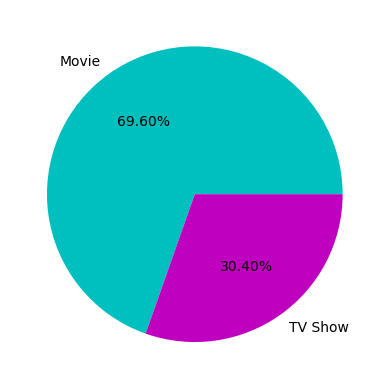

In [18]:
plt.pie(data['type'].value_counts(), labels = data['type'].value_counts().index, autopct = '%.2f%%', colors=['c','m'])
plt.show()

Netflix present more movies than TV shows. Nearly 70% of all productions are movies.

**Number of productions over the years**

<Axes: xlabel='Release Year', ylabel='Total Count'>

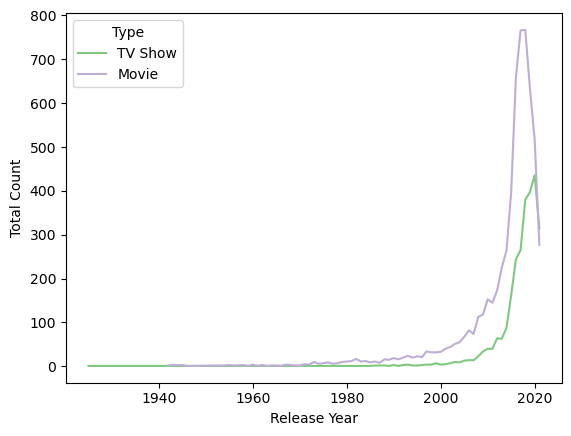

In [19]:
trend_data=data[['type', 'release_year']]
trend_data = trend_data.rename(columns = {'release_year':'Release Year', 'type': 'Type'})
trend_data = trend_data.groupby(['Release Year', 'Type']).size().reset_index(name='Total Count')
trend_data

line = sns.lineplot(trend_data, x='Release Year', y='Total Count', hue='Type', palette='Accent')
line

Since around 2015, there has been rapid growth in both TV shows and movies. Before the decline, there were more movies than TV shows. Netflix content saw a sharp decline around 2019, with TV shows surpassing movies for the first time.

**Movies distribution**

Text(0.5, 1.0, 'Distribution of Movie Durations')

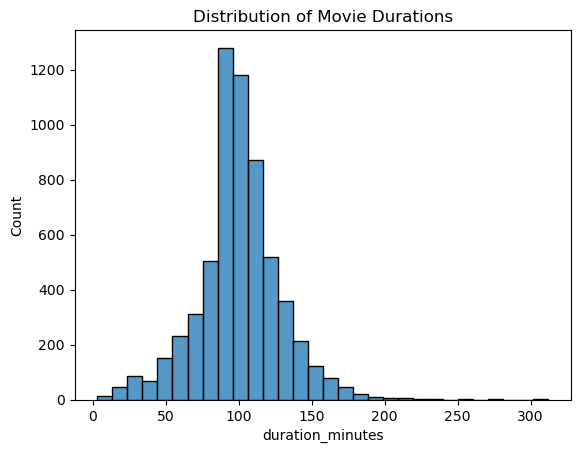

In [20]:
data_movie = data.loc[data['type'] == 'Movie'] 

movie=sns.histplot(data_movie, x="duration_minutes", bins=30)
movie.set_title('Distribution of Movie Durations')

Most movies last for 90 - 120 minutes. 

**The longest movies**

In [21]:
longest_movie=data_movie[['duration_minutes','title']].sort_values(by='duration_minutes', ascending =False)
longest_movie.head()

,duration_minutes,title
4253,312.0,Black Mirror: Bandersnatch
717,273.0,Headspace: Unwind Your Mind
2491,253.0,The School of Mischief
2487,237.0,No Longer kids
2484,233.0,Lock Your Girls In


**Shows distribution**

Text(0.5, 1.0, 'Distribution of Show Durations')

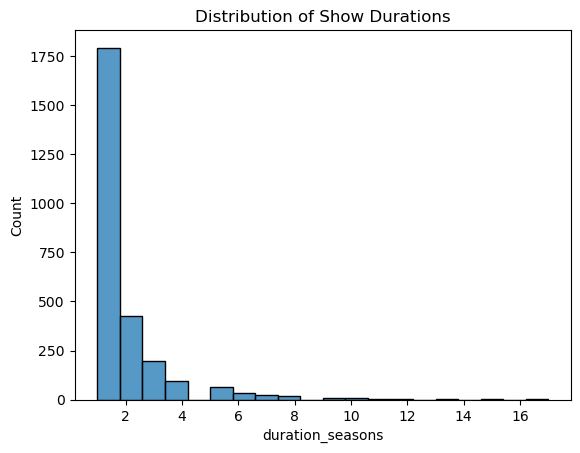

In [22]:
data_show = data.loc[data['type'] == 'TV Show'] 

show=sns.histplot(data_show, x="duration_seasons", bins=20)
show.set_title('Distribution of Show Durations')

Most series have 1 to 2 seasons.

**The longest shows**

In [23]:
longest_show=data_show[['duration_seasons','title']].sort_values(by='duration_seasons', ascending =False)
longest_show.head()

,duration_seasons,title
548,17.0,Grey's Anatomy
2423,15.0,Supernatural
4798,15.0,NCIS
1354,13.0,Heartland
4220,13.0,COMEDIANS of the world


**Directors**

<Axes: title={'center': 'Top 10 directors who have directed the most Netflix movies'}, xlabel='count', ylabel='director'>

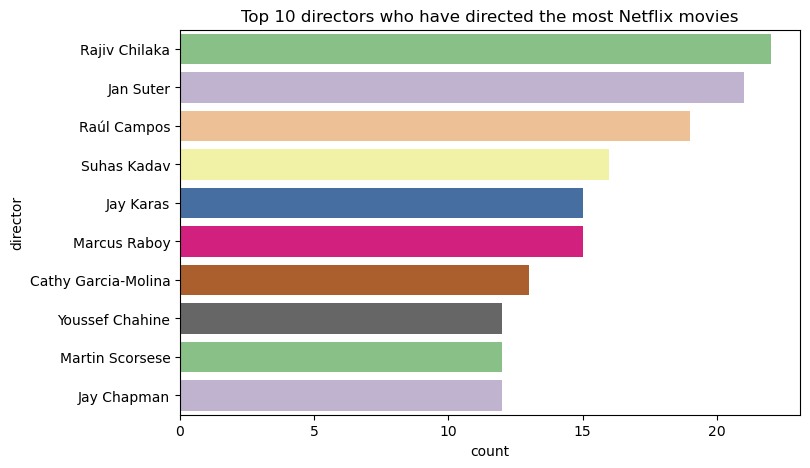

In [24]:
movie_directors= data_movie.director.str.split(', ').sum()
top_movie_directors = Counter(movie_directors)

top10_movie_directors = top_movie_directors.most_common(11)

df_top10_movie_directors = pd.DataFrame(top10_movie_directors, columns=['director', 'count'])
df_top10_movie_directors = df_top10_movie_directors.loc[df_top10_movie_directors['director'] != 'Unknown']

plt.figure(figsize=(8,5))
plt.title('Top 10 directors who have directed the most Netflix movies')
sns.barplot(data=df_top10_movie_directors,y='director',x='count',palette='Accent')

<Axes: title={'center': 'Top 10 directors who have directed the most Netflix shows'}, xlabel='count', ylabel='director'>

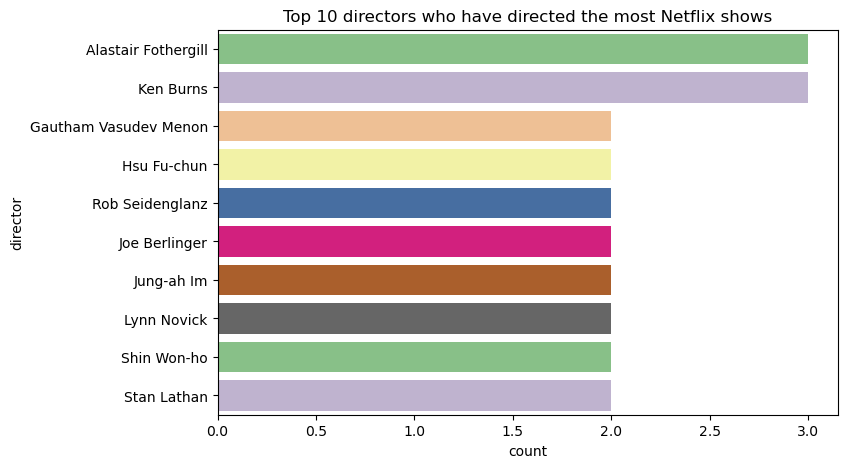

In [25]:
show_directors= data_show.director.str.split(', ').sum()
top_show_directors = Counter(show_directors)

top10_show_directors = top_show_directors.most_common(11)

df_top10_show_directors = pd.DataFrame(top10_show_directors, columns=['director', 'count'])
df_top10_show_directors = df_top10_show_directors.loc[df_top10_show_directors['director'] != 'Unknown']

plt.figure(figsize=(8,5))
plt.title('Top 10 directors who have directed the most Netflix shows')
sns.barplot(data=df_top10_show_directors,y='director',x='count' ,palette='Accent')

**Actors**

<Axes: title={'center': 'Top 10 actors from Netflix movies'}, xlabel='count', ylabel='cast'>

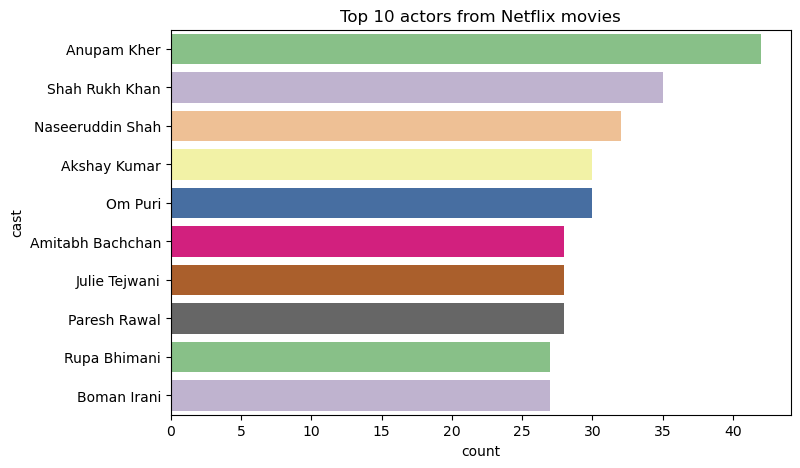

In [26]:
movie_cast= data_movie.cast.str.split(', ').sum()
top_movie_cast = Counter(movie_cast)

top10_movie_cast = top_movie_cast.most_common(11)

df_top10_movie_cast = pd.DataFrame(top10_movie_cast, columns=['cast', 'count'])
df_top10_movie_cast = df_top10_movie_cast.loc[df_top10_movie_cast['cast'] != 'Unknown']

plt.figure(figsize=(8,5))
plt.title('Top 10 actors from Netflix movies')
sns.barplot(data=df_top10_movie_cast,y='cast',x='count',palette='Accent')

<Axes: title={'center': 'Top 10 actors from Netflix shows'}, xlabel='count', ylabel='cast'>

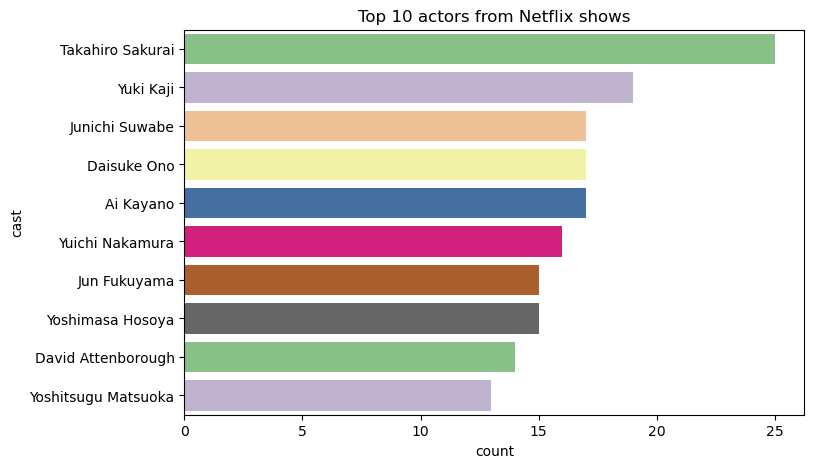

In [27]:
show_cast= data_show.cast.str.split(', ').sum()
top_show_cast = Counter(show_cast)

top10_show_cast = top_show_cast.most_common(11)

df_top10_show_cast = pd.DataFrame(top10_show_cast, columns=['cast', 'count'])
df_top10_show_cast = df_top10_show_cast.loc[df_top10_show_cast['cast'] != 'Unknown']

plt.figure(figsize=(8,5))
plt.title('Top 10 actors from Netflix shows')
sns.barplot(data=df_top10_show_cast,y='cast',x='count',palette='Accent')

**Countries**

<Axes: title={'center': 'Top 10 countries that make Netflix movies'}, xlabel='count', ylabel='country'>

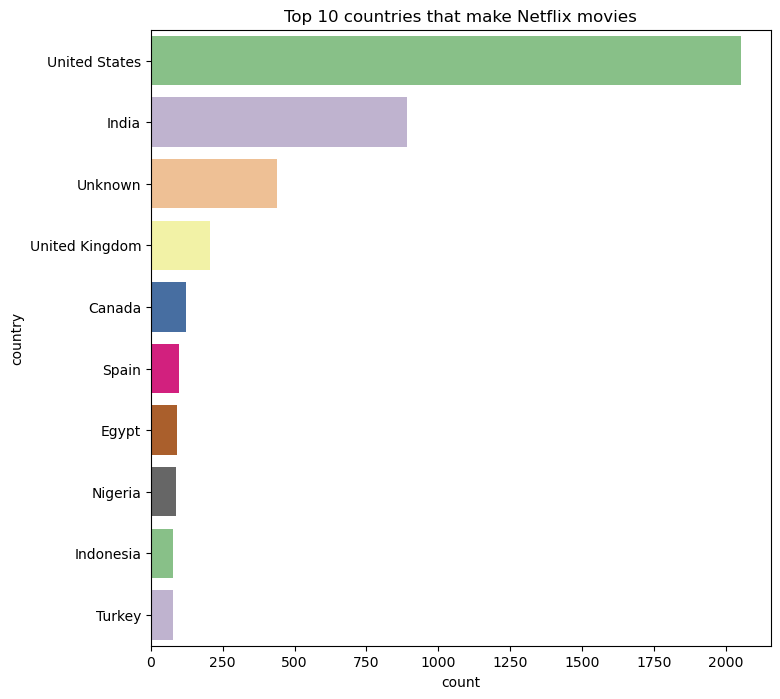

In [28]:

plt.figure(figsize=(8,8))
plt.title('Top 10 countries that make Netflix movies')
sns.countplot(data=data_movie,y='country',order=data_movie['country'].value_counts().index[0:10],palette='Accent')

Top Countries for Movies: United States, India, United Kingdom, Canada

<Axes: title={'center': 'Top 10 countries that make Netflix shows'}, xlabel='count', ylabel='country'>

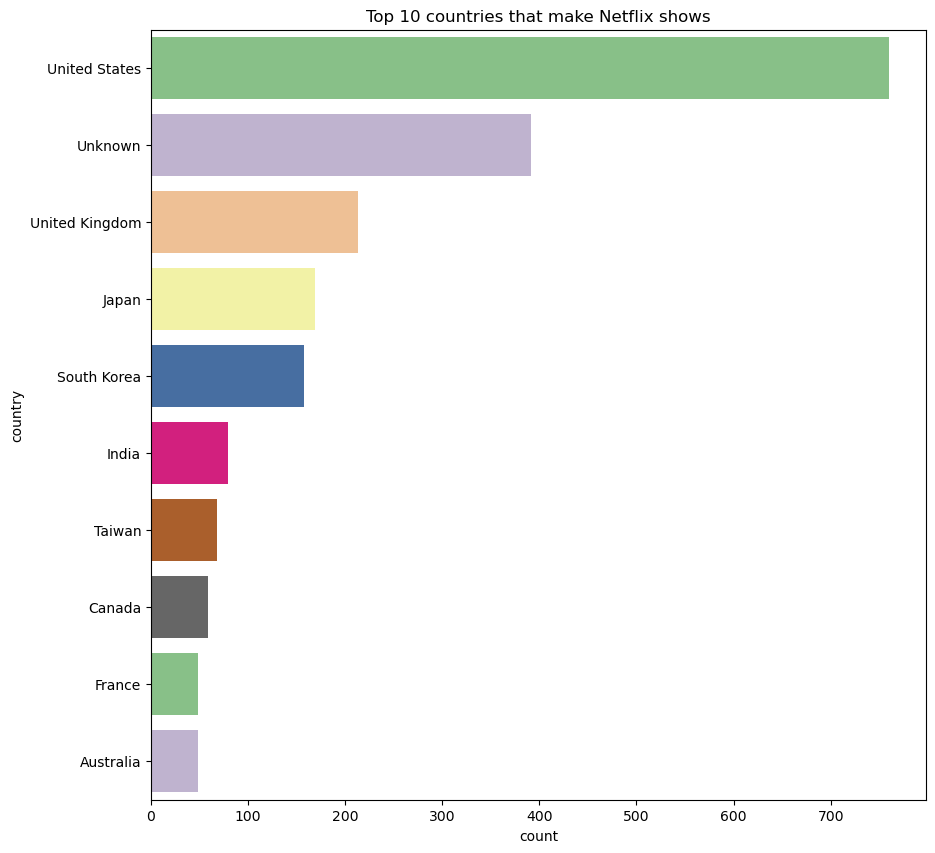

In [29]:
plt.figure(figsize=(10,10))
plt.title('Top 10 countries that make Netflix shows')
sns.countplot(data=data_show,y='country',order=data_show['country'].value_counts().index[0:10],palette='Accent')

Top Countries for TV Shows: United States, United Kingdom, Japan, South Korea


**Ratings**

In [30]:
data_movie['rating'].unique()

array(['PG-13', 'PG', 'TV-MA', 'TV-PG', 'TV-14', 'TV-Y', 'R', 'TV-G',
       'TV-Y7', 'G', 'NC-17', 'NR', 'TV-Y7-FV'], dtype=object)

In [31]:
data_show['rating'].unique()

array(['TV-MA', 'TV-14', 'TV-Y7', 'TV-PG', 'TV-Y', 'TV-G', 'R', 'NR',
       'TV-Y7-FV'], dtype=object)

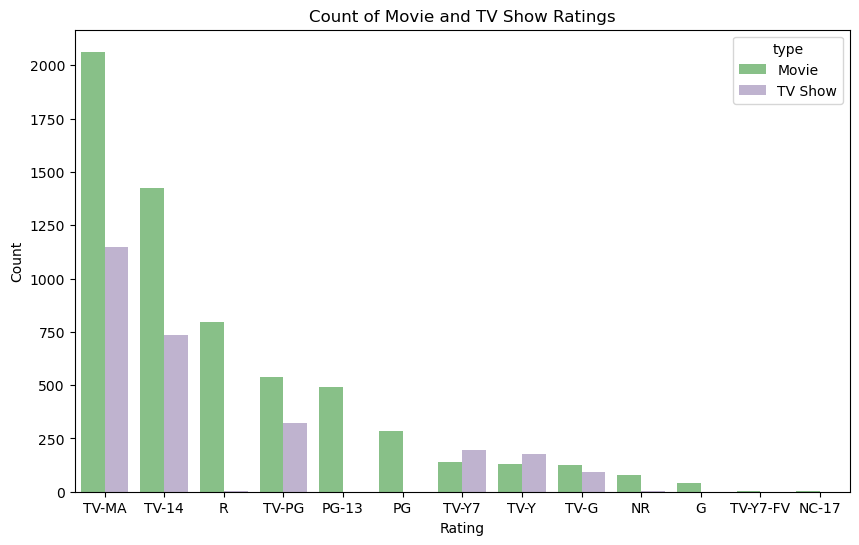

In [32]:
rating_order = data_movie['rating'].value_counts().index

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='rating',  hue='type', order=rating_order, palette='Accent')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Count of Movie and TV Show Ratings')
plt.show()

TV-MA, TV-14, R  are top ratings in Netflix movies.

TV-MA. TV-14, TV-PG are top rating in Netflix shows.

Movies contain more types than tv shows.


**Oldest movies**

In [33]:
year = data_movie.sort_values("release_year", ascending = True)
year[['title', "release_year"]].head()

,title,release_year
8205,The Battle of Midway,1942
7790,Prelude to War,1942
8763,WWII: Report from the Aleutians,1943
8739,Why We Fight: The Battle of Russia,1943
8660,Undercover: How to Operate Behind Enemy Lines,1943


**Oldest shows**

In [34]:
year = data_show.sort_values("release_year", ascending = True)
year[['title', "release_year"]].head()

,title,release_year
4250,Pioneers: First Women Filmmakers*,1925
1331,Five Came Back: The Reference Films,1945
7743,Pioneers of African-American Cinema,1946
8541,The Twilight Zone (Original Series),1963
8189,The Andy Griffith Show,1967


**Genres**

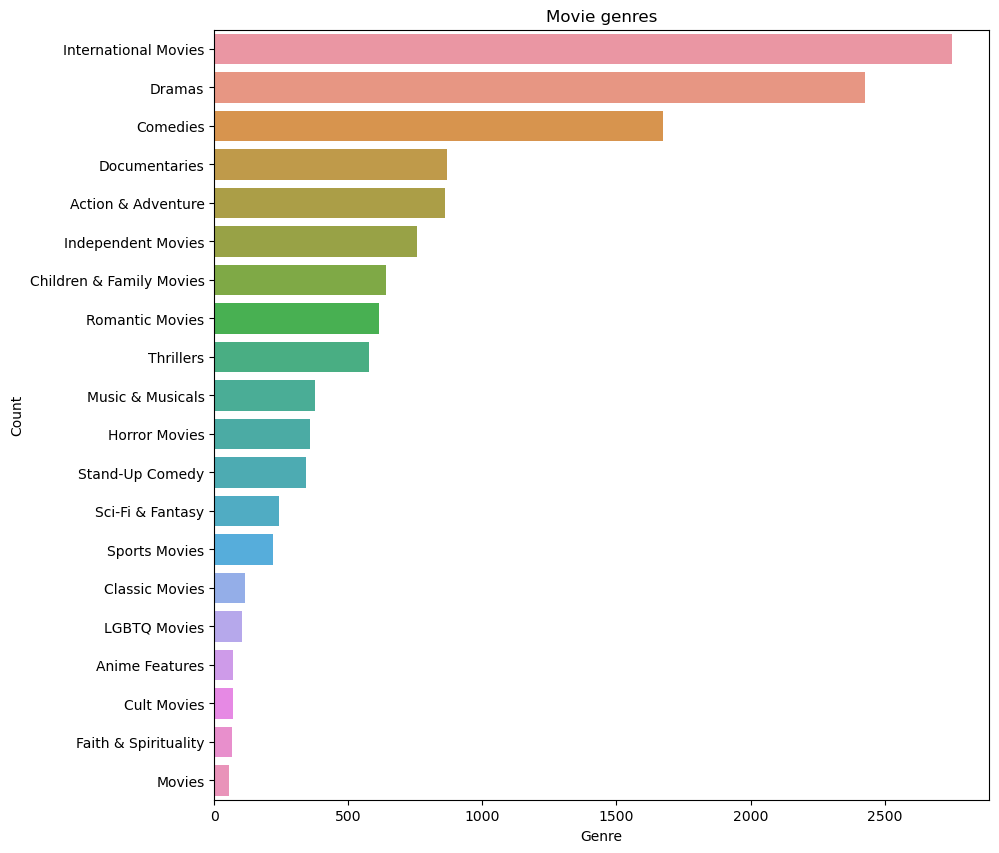

In [35]:
genre_movie = data_movie['listed_in'].str.split(', ').explode().value_counts()

plt.figure(figsize=(10, 10))
sns.barplot(y=genre_movie.index, x=genre_movie.values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Movie genres')
plt.show()

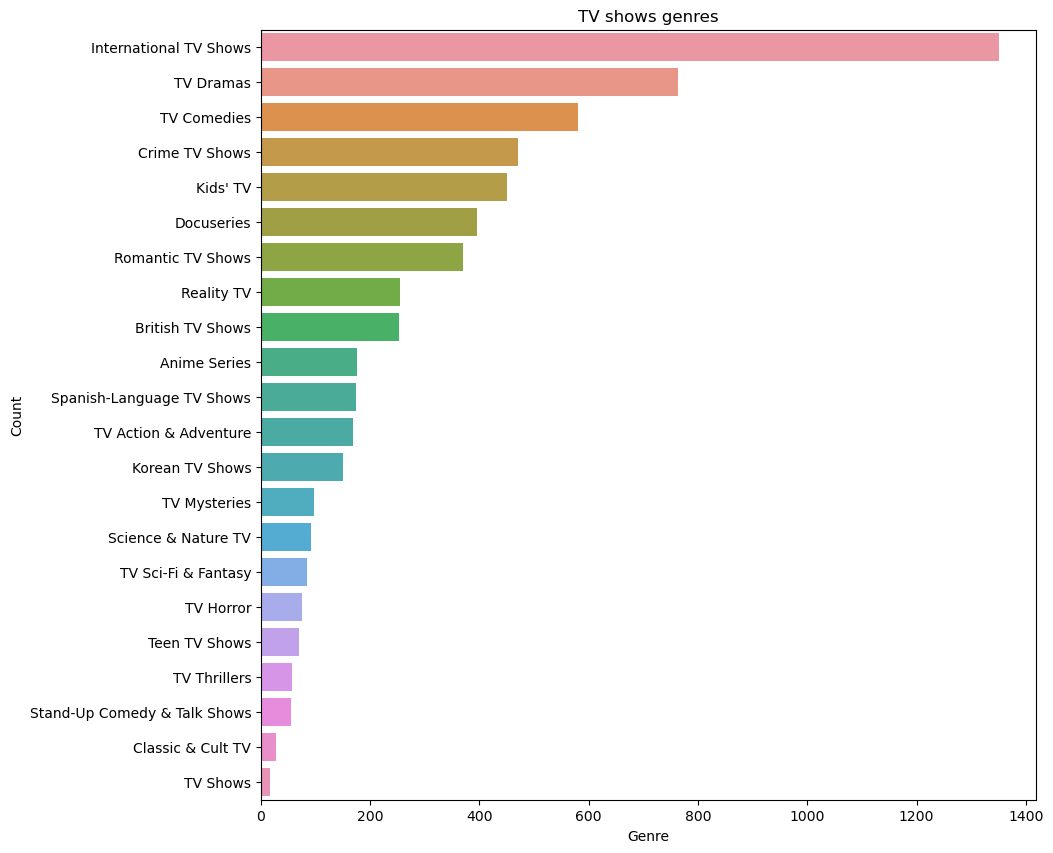

In [36]:
genre_show = data_show['listed_in'].str.split(', ').explode().value_counts()

plt.figure(figsize=(10, 10))
sns.barplot(y=genre_show.index, x=genre_show.values)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('TV shows genres')
plt.show()

**Polish productions available on Netflix**

In [37]:
pl = data[data['country'] == 'Poland']
pl[['title','director','type','release_year']].sort_values(by='release_year', ascending =False)

,title,director,type,release_year
377,Bartkowiak,Daniel Markowicz,Movie,2021
503,The Mire,Jan Holoubek,TV Show,2021
968,Sexify,Unknown,TV Show,2021
1326,Squared Love,Filip Zylber,Movie,2021
1346,All My Friends Are Dead,Jan Belcl,Movie,2020
1606,Fierce,Anna Wieczur-Bluszcz,Movie,2020
1788,Nobody Sleeps in the Woods Tonight,Bartosz M. Kowalski,Movie,2020
1993,Signs,Unknown,TV Show,2020
2198,The Hater,Jan Komasa,Movie,2020
2412,365 Days,"Barbara Białowąs, Tomasz Mandes",Movie,2020


**Conclusions**

I drew many interesting inferences from the Netflix dataset. 
This is a summary of the few of them:

* The most productions on Netflix are movies,
* For several years, netflix has more TV shows than movies,
* The country that produces the most content is the United States,
* Rajiv Chilaka has directed the most Netflix movies and Alastair Fothergill has directed the most TV shows,
* Anupum Kaur starred in the most movies and Takahiro Sakurai starred in the most TV shows,
* TV-MA and TV-14 are the highest rated movies and TV seres,
* The most popular productions are international films and series, dramas and comedies.